# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [2]:
import pandas as pd
import numpy as np

In [40]:
from sklearn.preprocessing import LabelEncoder
# This can be used to load the dataset
data = pd.read_csv("adult.csv", header=0, na_values='?')



data['salary'] = data['salary'].map({'<=50K': 1, '>50K': 0})

# le = LabelEncoder()
data = data.drop(columns=['fnlwgt'])  # this is the amount of people a certain statistic reprisents, so not necessary for predicting salary

# strings = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
# for string in strings:
#     data[string] = le.fit_transform(data[string])
data = data.dropna()
data.head()


# check_nan = data['age'].isnull().values.any()
# print(data.columns[data.isna().any()].tolist())
# # printing the result
# print(check_nan)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1.0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1.0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1.0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1.0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1.0


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [55]:
from numpy import mean, absolute, std

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score


# Define your preprocessing steps here   (Name, Object, Columns)
def main(data, splits):
    
    
    categorical_cols = ['workclass','education','marital-status',
                        'occupation','relationship','race','sex','native-country']


    y = data['salary']
    X = data.drop(columns = ['salary'])
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    steps = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols), ('num', StandardScaler(), numeric_cols)]
    
    model = LogisticRegression()

    mean, std = apply_model(model, X, y, splits)
    
    return mean, std

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)

# show the correlation between different features including target variable
def visualize(data, ct):
    print('visualizer:')
    print(ct.fit_transform(data))
    
# Apply your model to feature array X and labels y
def apply_model(model, X, y, splits):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline, splits)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline, splits):
    # define the model cross-validation configuration
    cv = KFold(n_splits=splits, shuffle=True, random_state=1)
    # evaluate the pipeline using cross validation and calculate MAE
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    

    # convert MAE scores to positive values
    scores = absolute(scores)
    # summarize the model performance

    print('MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)



main(data, 5)

MAE: 0.847 (0.006)


(0.8471252991394369, 0.005641847961088173)

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [56]:
from random import sample

"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = y.copy()

    n_rows = len(copy)
    to_alter = int(fraction * n_rows)

    rows_to_alter = sample(list(copy.index), to_alter)
    copy.loc[rows_to_alter, 'salary'] = 1 - copy.loc[rows_to_alter, 'salary']

    return copy

copy = pertubate(data, 0.5)

check_nan = copy['salary'].isnull().values.any()
print(copy.columns[copy.isna().any()].tolist())

print(check_nan)
copy.head()


[]
False


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1.0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0.0


#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

MAE: 0.847 (0.006)
MAE: 0.775 (0.006)
MAE: 0.701 (0.007)
MAE: 0.635 (0.004)
MAE: 0.564 (0.003)
MAE: 0.490 (0.002)


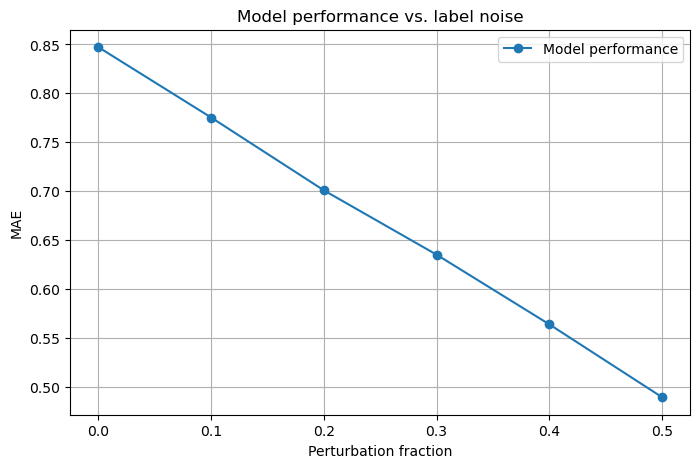

In [58]:
import matplotlib.pyplot as plt

x = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
y = []

for i in range(0, 6, 1):
    pertrubation_level = i / 10
    
    mean, std = main(pertubate(data, pertrubation_level), 5)
    
    y.append(mean)

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', label="Model performance")

plt.xlabel("Perturbation fraction")
plt.ylabel("MAE")
plt.title("Model performance vs. label noise")
plt.legend()
plt.grid(True)
plt.show()

    
    


Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



In [ ]:
def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    pass

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words